In [1]:
from d2l import AllDeepLearning as d2l
from d2l import d2l_mx
from mxnet import autograd, gluon, nd
from mxnet.gluon import nn
from AI.AILearning.NaturalLanguageProcessing import WordEmbedding as loader

import math
import random
import zipfile
import time




In [2]:
with zipfile.ZipFile('../../data/ptb.zip', 'r') as f:
    raw_text = f.read('ptb/ptb.train.txt').decode("utf-8").lower()

sentences = [line.split() for line in raw_text.split("\n")]
'sentences: %d' % len(sentences)


'sentences: 42069'

In [3]:
# Build vocabulary
def expand(sentences):
    """
    Expand list of token lists into a list of tokens
    :param sentences:
    :return:
    """
    return [tk for line in sentences for tk in line]

vocab = d2l_mx.Vocab(expand(sentences), min_freq=10)
'vocab size: %d' % len(vocab)


'vocab size: 6719'

In [4]:
import collections
# Subsampling
# Map low frequency words into <unk>
sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line] for line in sentences]
tokens = expand(sentences)
counter = collections.Counter(tokens)

def discard(token):
    """

    :param token:
    :return: should discard token when it has too high frequency
    """
    p = 1 - math.sqrt(1e-4 / counter[token] * len(tokens))
    return random.uniform(0, 1) < p

subsampled = [[tk for tk in line if not discard(tk)] for line in sentences]
subsampled.__len__()

42069

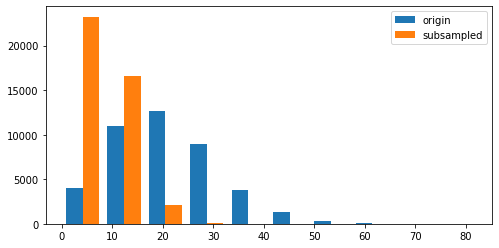

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.hist([[len(line) for line in sentences], [len(line) for line in subsampled]])
plt.legend(['origin', 'subsampled'])

In [6]:
def compare_counts(token):
    return 'count of "%s": before-%d, after-%d' % (
        token,
        sum([line.count(token) for line in sentences],),
        sum([line.count(token) for line in subsampled])
    )

compare_counts('join')

'count of "join": before-45, after-45'

In [7]:
# Map each token into index to construct corpus
corpus = [vocab[line] for line in subsampled]
corpus[:6]

[[0, 0, 0],
 [71, 2132, 18, 275],
 [140, 5464, 3080, 1595],
 [2476, 656, 2169, 954, 38, 302, 437, 3683],
 [941,
  3,
  3149,
  262,
  4,
  6091,
  4240,
  6035,
  987,
  240,
  759,
  1014,
  2785,
  95,
  430,
  4114,
  4,
  1243],
 [3149, 4051, 495, 21, 112, 2651, 2473, 5249, 3003, 465, 1243]]

In [8]:
# extract central target words and context words
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Need at least 2 words to form a central target - context word
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size), min(len(line), i + 1 + window_size)))
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

tiny_dataset=[list(range(7)),list(range(7,10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset,2)):
    print('center', center,'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2]
center 2 has contexts [1, 3]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [3, 4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In [9]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
'center-context pairs: %d' % len(all_centers)

'center-context pairs: 353163'

In [10]:
class RandomGenerator(object):
    """
    Draw a random int in [0, n] according to n sampling weights
    """
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # cache 10000 random number
            self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]


generator = RandomGenerator([2, 3, 4])
generator.draw()

0

In [11]:
counter = collections.Counter(expand(corpus))
sampling_weights = [counter[i] ** 0.75 for i in range(len(counter))]

def get_negatives(all_ctxs, sampling_weights, K):
    all_negatives = []
    generator = RandomGenerator(sampling_weights=sampling_weights)
    for contexts in all_ctxs:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise word cannot be ctx words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, sampling_weights=sampling_weights, K=5)

In [17]:
import numpy as np
def batchify(data):
    """
    Construct mini-batch by concatenate the ctx word and noise word of each example and add 0s for padding
    To avoid effect of padding on the loss func, using mask variable with same shape and has value 0 if position is
    padding otherwise is 1
    To know which is the positive and negative samples, using labels variable similar to masks variable
    :param data:
    :return:
    """
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return np.array(centers).reshape((-1, 1)), np.array(contexts_negatives), np.array(masks), np.array(labels)


x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negative', "masks", 'labels']
for name, data in zip(names, batch):
    print(name, '-', data)

centers - [[1]
 [1]]
contexts_negative - [[2 2 3 3 3 3]
 [2 2 2 3 3 0]]
masks - [[1 1 1 1 1 1]
 [1 1 1 1 1 0]]
labels - [[1 1 0 0 0 0]
 [1 1 1 0 0 0]]


In [20]:
# dataset with batch size 512 contain center, context, mask and label
batch_size = 512
dataset = gluon.data.ArrayDataset(all_centers, all_contexts, all_negatives)
data_iter = gluon.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, batchify_fn=batchify)
# each loop with take a tuple of batch_size center, context, mask and label
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape =', data.shape)
    break

centers shape = (512, 1)
contexts_negative shape = (512, 60)
masks shape = (512, 60)
labels shape = (512, 60)


In [21]:
embed = nn.Embedding(input_dim=20, output_dim=4)
embed.initialize()
embed.weight

Parameter embedding0_weight (shape=(20, 4), dtype=float32)

In [24]:
# the input of embedding layer is index of word, When enter index i of word
# the embedding layer return the ith row of the weight matrix as its word vector
embed(nd.array([1]))


[[0.01438687 0.05011239 0.00628365 0.04861524]]
<NDArray 1x4 @cpu(0)>

In [26]:
# mini batch multiplication
# a batch with shape (n, a, b) and another batch with shape (n, a, c) with n is batch_size multi
# return batch with shape (n, a, c)
X = nd.ones((1, 3, 5))
Y = nd.ones((1, 5, 2))
nd.batch_dot(X, Y).shape

(1, 3, 2)

In [30]:
# in forward in skip-gram the central word has shape (batch_size, 1)
# and the concatenate context negative words has shape (batch_size, max_len), which will
# be transform from word indexes to word vectors by the word embedding layer
# and the output with shape (batch_size, 1, max_len) is obtained by mini batch dot

def skip_gram(center, contexts_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_negatives)
    pred = nd.batch_dot(v, u.swapaxes(1, 2))
    return pred

skip_gram(nd.ones((2,1)), nd.ones((2,3)), embed, embed).shape

(2, 4, 3)


(2, 1, 3)

In [33]:
# Use mask to avoid padding participate in loss calculation
# when the mask is 0 the pred value will not take affect, 1 otherwise
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
pred = nd.array([[.5]*4]*2)
label = nd.array([[1, 0, 1, 0]]*2)
mask = nd.array([[1, 1, 1, 0], [1, 1, 0, 0]])
print(pred.shape, label.shape, mask.shape)
loss(pred, label, mask)

(2, 4) (2, 4) (2, 4)



[0.48055774 0.3620385 ]
<NDArray 2 @cpu(0)>